# 02: Training

This notebook loads the data from the previous notebook and trains a model to predict forest attributes. The model is evaluated and saved to disk for later use.

In [103]:
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from aim import Image, Run
from aim.keras import AimCallback
from sklearn.metrics import r2_score

from naip_cnn import models
from naip_cnn.data import NAIPDatasetWrapper
from naip_cnn.inference import predict_image

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [104]:
BANDS = ("R", "G", "B", "N")
LABEL = "rh95"
BATCH_SIZE = 128
DATASET_NAME = "MAL2016_CanyonCreek-1-30-150x150-150"

EPOCHS = 250
PATIENCE = 25
LEARN_RATE = 0.001

## Load Data

Before training, we need load our dataset, split it into training and validation sets, and divide it into batches. The same `TrainingDataset` class we used to generate the dataset can be re-used now for training. All of the parameters we defined when generating our training dataset are stored in the file name, allowing us to load a complete `TrainingDataset` from the file we exported earlier.

Additional parameters like the NAIP bands to include, the LiDAR attribute to predict, and the model batch size are defined separately.

In [105]:
wrapper = NAIPDatasetWrapper.from_filename(DATASET_NAME)

train = (
    wrapper.dataset.load_train(label=LABEL, bands=BANDS)
    .cache()
    .shuffle(buffer_size=10_000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

val = (
    wrapper.dataset.load_val(label=LABEL, bands=BANDS)
    .cache()
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

## Build and Train Model

With the data loaded, we can build a CNN model and train it. The `ModelRun` class wraps a Keras model and a `TrainingDataset` and is used to organize, identify, and export a given model run.

In [106]:
model = models.CNN_v2(
    shape=(*wrapper.naip_shape, len(BANDS)), out_shape=wrapper.lidar_shape
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARN_RATE),
    loss="mse",
    metrics=["mae", "mse"],
)

run = models.ModelRun(
    model=model,
    dataset=wrapper,
    label=LABEL,
    bands=BANDS,
)

While training the model, we'll use two callbacks: 

- `EarlyStopping` interrupts training if loss stops improving after the number of epochs defined by `patience`. This can reduce training time by aborting once a model starts to overfit, when further epochs are unlikely to improve model performance. Lower `patience` values stop the model sooner, but may trigger prematurely due to random fluctuations in loss.
- `ModelCheckpoint` stores the weights of the best performing epoch, allowing us to restore the optimal model if later epochs begin to overfit. 

*Note that while `EarlyStopping` *can* restore weights, this only works if the callback is triggered, which may not happen if `patience` is not exceeded.*

In [107]:
logging_callback = AimCallback()
experiment = logging_callback.experiment

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", verbose=1, patience=PATIENCE, restore_best_weights=False
)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        # keras does a second formatting run for the epoch
        filepath=f"../models/.checkpoint_{run.name}_{{epoch:04d}}.h5",
        save_best_only=True,
        save_weights_only=True,
        verbose=False,
        monitor="val_loss",
    ),
    early_stopping,
    logging_callback,
]

run.model.fit(
    train,
    verbose=1,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/250
116/116 [==============================] - 75s 339ms/step - loss: 76.2260 - mae: 6.7035 - mse: 76.2260 - val_loss: 42.2499 - val_mae: 4.9997 - val_mse: 42.2499
Epoch 2/250
116/116 [==============================] - 6s 52ms/step - loss: 42.7064 - mae: 5.1189 - mse: 42.7064 - val_loss: 39.7380 - val_mae: 4.8241 - val_mse: 39.7380
Epoch 3/250
116/116 [==============================] - 7s 57ms/step - loss: 40.5393 - mae: 4.9896 - mse: 40.5393 - val_loss: 38.2050 - val_mae: 4.7553 - val_mse: 38.2050
Epoch 4/250
116/116 [==============================] - 7s 58ms/step - loss: 38.0127 - mae: 4.8271 - mse: 38.0127 - val_loss: 37.0131 - val_mae: 4.8310 - val_mse: 37.0131
Epoch 5/250
116/116 [==============================] - 7s 58ms/step - loss: 36.7510 - mae: 4.7444 - mse: 36.7510 - val_loss: 35.6454 - val_mae: 4.6044 - val_mse: 35.6454
Epoch 6/250
116/116 [==============================] - 7s 58ms/step - loss: 34.8402 - mae: 4.6151 - mse: 34.8402 - val_loss: 37.8872 - val_mae: 4.95

In [108]:
best_epoch = run.load_best_checkpoint()
stopped_epoch = early_stopping.stopped_epoch if early_stopping else EPOCHS
run.save_model()

metrics = run.model.evaluate(val)

14/14 [==============================] - 0s 24ms/step - loss: 32.3472 - mae: 4.4149 - mse: 32.3472


## Log Parameters

In [109]:
def log_params(
    experiment: Run,
    *,
    dataset: NAIPDatasetWrapper,
    model_run: models.ModelRun,
    bands: Tuple[str],
    label: str,
    batch_size: int,
    learn_rate: float,
    epochs: int
):
    """Log parameters from a model run to an Aim experiment."""
    experiment["params"] = {
        "training": {
            "batch_size": batch_size,
            "learning_rate": learn_rate,
            "epochs": epochs,
        },
        "model": {
            "architecture": model_run.model.name,
            "path": model_run.model_path.as_posix(),
        },
        "data": {
            "path": dataset.hdf_path.as_posix(),
            "date": {
                "start": dataset.acquisition.start_date,
                "end": dataset.acquisition.end_date,
            },
            "footprint": {
                "shape": dataset.footprint,
                "spacing": dataset.spacing,
            },
            "imagery": {
                "bands": "".join(bands),
                "resolution": dataset.naip_res,
                "acquisition": dataset.acquisition.name,
            },
            "lidar": {
                "label": label,
                "resolution": dataset.lidar_res,
                "asset": dataset.acquisition.lidar_asset,
            },
        },
    }

In [110]:
log_params(
    experiment,
    dataset=wrapper,
    model_run=run,
    bands=BANDS,
    label=LABEL,
    batch_size=BATCH_SIZE,
    learn_rate=LEARN_RATE,
    epochs=EPOCHS,
)

## Log Metrics

In [111]:
y_pred = run.model.predict(val)
y_true = np.concatenate([data[1] for data in val.as_numpy_iterator()])

experiment.track(best_epoch, "best_epoch")
experiment.track(stopped_epoch, "stopped_epoch")
experiment.track(
    r2_score(y_true.ravel(), y_pred.ravel()), "r2_score", context={"subset": "val_best"}
)

for metric, value in zip(run.model.metrics_names, metrics):
    experiment.track(value, metric, context={"subset": "val_best"})

 4/14 [=======>......................] - ETA: 0s

14/14 [==============================] - 0s 26ms/step


## Log Figures

### Correlation Scatterplot

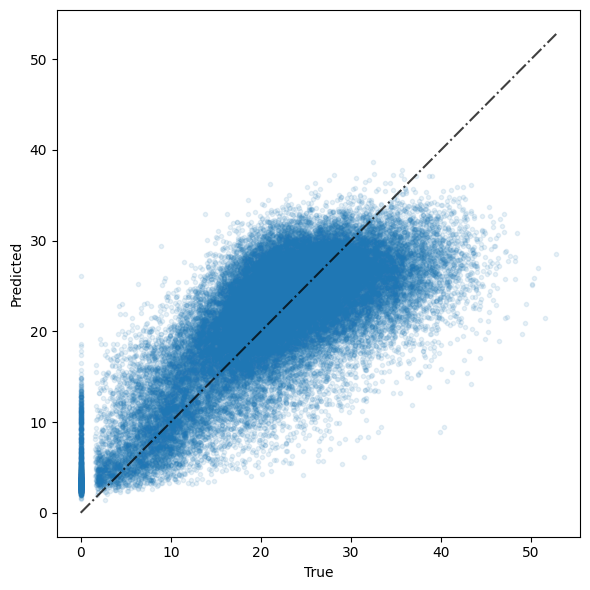

In [112]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(y_true, y_pred, alpha=0.1, marker=".")
ax.plot((y_true.min(), y_true.max()), (y_true.min(), y_true.max()), "k-.", alpha=0.75)
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
plt.tight_layout()

In [113]:
experiment.track(Image(fig, optimize=True), name="scatter_plot")

### Distribution Histograms

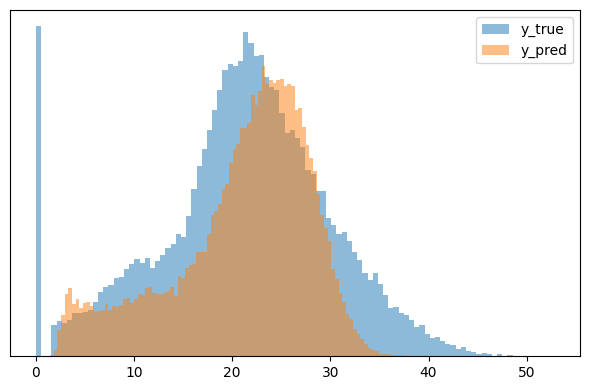

In [114]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(y_true.ravel(), bins=100, alpha=0.5, label="y_true")
ax.hist(y_pred.ravel(), bins=100, alpha=0.5, label="y_pred")
ax.legend()
ax.set_yticks([])
plt.tight_layout()

In [115]:
experiment.track(Image(fig, optimize=True), name="histogram")

### Validation Predictions

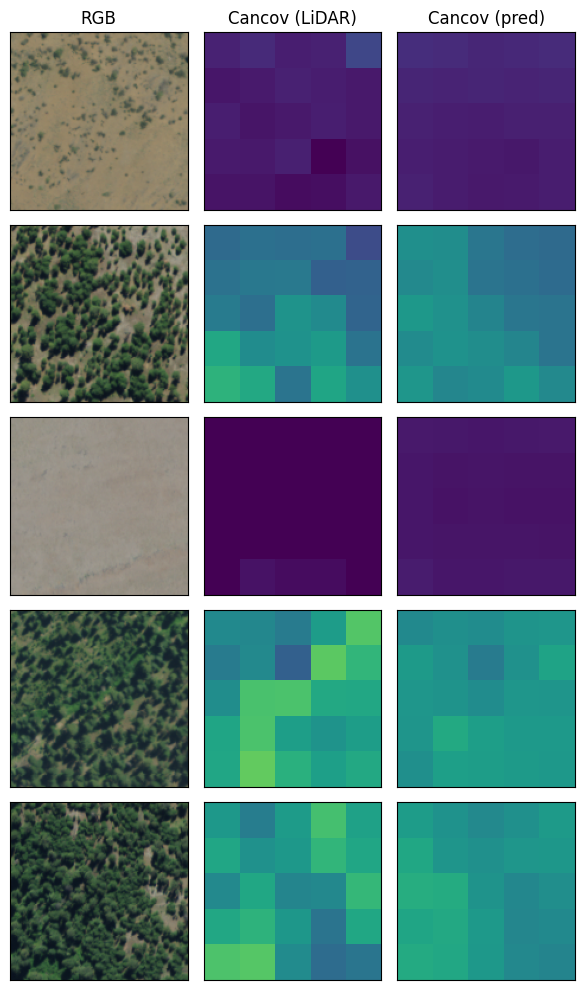

In [116]:
X_ref = np.concatenate([data[0] for data in val.as_numpy_iterator()])
rng = np.random.default_rng(99)
check_samples = rng.choice(range(len(X_ref)), size=5, replace=False)

fig, ax = plt.subplots(len(check_samples), 3, figsize=(6, 2 * len(check_samples)))

for i, sample in enumerate(check_samples):
    ax[i, 0].imshow(X_ref[sample, ..., :3])
    ax[i, 1].imshow(y_true[sample, ...], vmin=y_true.min(), vmax=y_true.max())
    ax[i, 2].imshow(y_pred[sample, ...], vmin=y_true.min(), vmax=y_true.max())

ax[0, 0].set_title("RGB")
ax[0, 1].set_title("Cancov (LiDAR)")
ax[0, 2].set_title("Cancov (pred)")

# Remove ticks
for sub_ax in ax.ravel():
    sub_ax.set_xticks([])
    sub_ax.set_yticks([])

plt.tight_layout()

In [117]:
experiment.track(Image(fig, optimize=True), name="validation_chips")

## Log Images

Run `python scripts/export_evaluation_naip.py` before running the cell below.

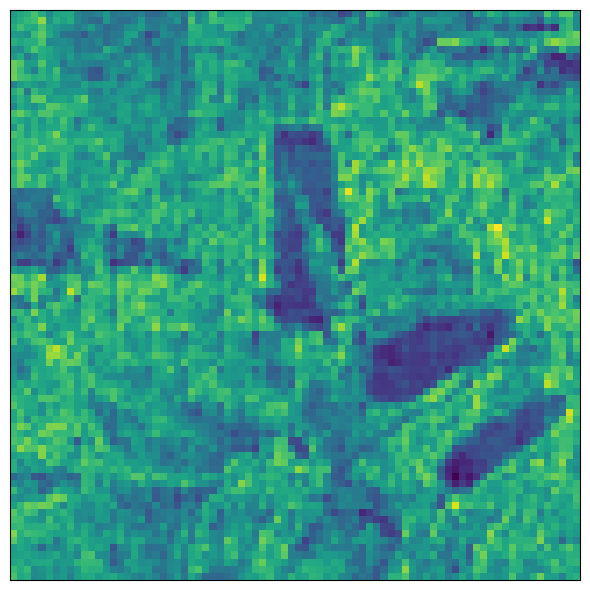

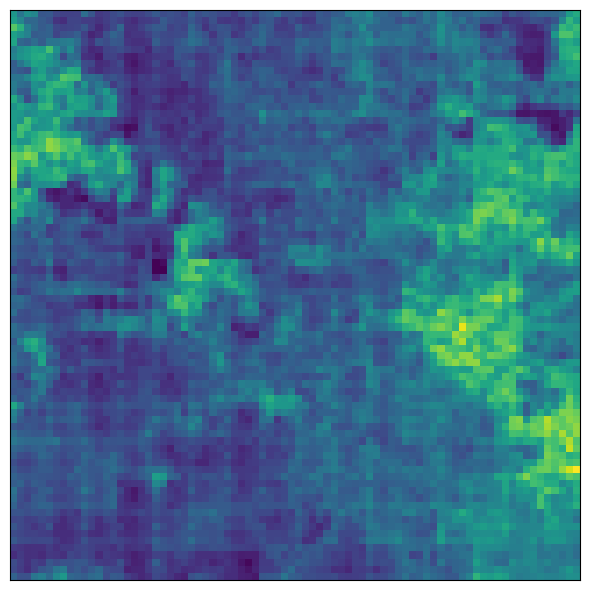

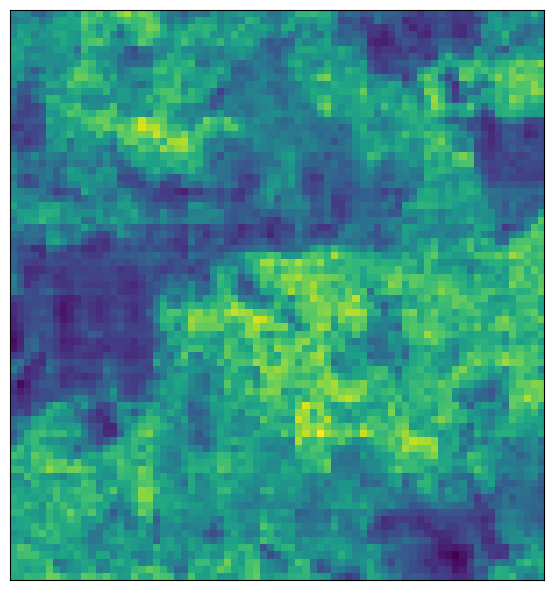

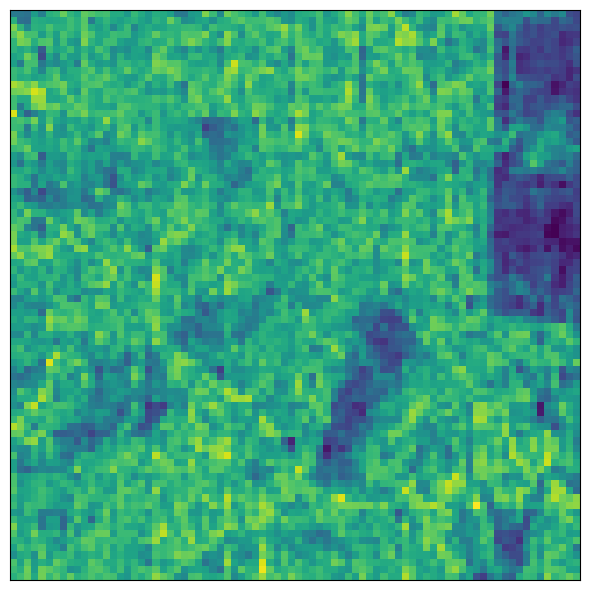

In [118]:
for img_path in Path("../data/naip/").glob("*.tif"):
    pred_img = predict_image(
        img_path=img_path,
        model=run.model,
        in_tile_shape=(*wrapper.naip_shape, len(BANDS)),
        out_tile_shape=wrapper.lidar_shape,
        in_res=wrapper.naip_res,
        out_res=wrapper.lidar_res,
    )

    vis_img = (
        (((pred_img - y_true.min()) / y_true.max()) * 255)
        .clip(0, 255)
        .astype(np.uint8)
        .values
    )

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(vis_img)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    experiment.track(Image(fig), name=f"{img_path.stem}")

## Tear Down

In [119]:
if experiment.active:
    experiment.close()